# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import scanpy_scripts as ss
import bbknn
import phate

np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
expr_cmap = ss.lib.expression_colormap()
ss.lib.set_figsize((4, 4))

# Processing

In [2]:
organoid_ad = sc.read('organoid.cellxgene.h5ad')

In [6]:
organoid_ad

AnnData object with n_obs × n_vars = 130811 × 27320 
    obs: 'sample_id', 'version', 'week', 'day', 'strain', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_bk_split5', 'nh3_annot1', 'nh3_broad_annot1'
    var: 'gene_ids', 'gene_symbols', 'highly_variable'
    obsm: 'X_umap_hm', 'X_umap_bk'

In [ ]:
ss.lib.plot_embedding(organoid_ad, basis='umap_bk', groupby='nh3_broad_annot1')

In [171]:
ss.lib.cross_table(organoid_ad, 'nh3_annot1', 'strain')

strain,DSP,WA25
nh3_annot1,,
Endothelium,63,67
Merkel,56,83
Melanocytes,605,785
CNCC-like / Schwann,810,1612
CNCC-like,1415,685
Neuron progenitors,562,931
Immature neurons,761,754
Peridermal KC,465,689
Basal stem-like KC,1183,1526


In [173]:
organoid_ad.obs['week'].value_counts()

17-20_fetal_wks    72164
7-10_fetal_wks     21803
14-16_fetal_wks    18440
4-7_fetal_wks      18404
Name: week, dtype: int64

In [172]:
organoid_ad.obs['day'].value_counts()

day-133    72164
day-48     21803
day-85     18440
day-29     18404
Name: day, dtype: int64

In [128]:
organoid_ad.obs['nh3_broad_annot1'].value_counts()

Stroma           98067
Keratinocytes    23555
Neuronal          7530
Melanocytes       1390
Merkel             139
Endothelium        130
Name: nh3_broad_annot1, dtype: int64

In [3]:
ads = ss.lib.split_by_group(organoid_ad, groupby='nh3_broad_annot1')

In [8]:
ads

{'Endothelium': AnnData object with n_obs × n_vars = 130 × 27320 
     obs: 'sample_id', 'version', 'week', 'day', 'strain', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_bk_split5', 'nh3_annot1', 'nh3_broad_annot1'
     var: 'gene_ids', 'gene_symbols', 'highly_variable'
     obsm: 'X_umap_hm', 'X_umap_bk',
 'Keratinocytes': AnnData object with n_obs × n_vars = 23555 × 27320 
     obs: 'sample_id', 'version', 'week', 'day', 'strain', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_bk_split5', 'nh3_annot1', 'nh3_broad_annot1'
     var: 'gene_ids', 'gene_symbols', 'highly_variable'
     obsm: 'X_umap_hm', 'X_umap_bk',
 'Melanocytes': AnnData object with n_obs × n_vars = 1390 × 27320 
     obs: 'sample_id', 'version', 'week', 'day', 'strain', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_bk_split5', 'nh3_annot1', 'nh3_broa

In [ ]:
del organoid_ad

### Neuronal

In [81]:
fST_ad = sc.read('../data/h5ad/20200114/fetal_skin.stroma.doublet_removed_processed.20200114.h5ad')

Only considering the two last: ['.20200114', '.h5ad'].
Only considering the two last: ['.20200114', '.h5ad'].


In [82]:
fST_ad

AnnData object with n_obs × n_vars = 134005 × 27117 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'rachel_annot2'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_bk', 'neighbors_hm', 'pca', 'rachel_annot2_colors'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm', 'X_umap_bk'
    varm: 'PCs'

In [83]:
fST_ad.obs['rachel_annot2'].value_counts()

Fibroblast                102089
Smooth muscle/pericyte     10265
Muscle/myofibroblast        6622
MSC                         6288
Schwann cells               5305
Adipocyte                   2200
Unknown                     1236
Name: rachel_annot2, dtype: int64

In [85]:
fST_ad.obs['annot'].value_counts()

nan                         81299
fs_Fibroblast               41052
fs_Fibroblast_prolif         3556
fs_unknown                   2422
fs_Smooth muscle             2077
fs_Schwann cell               916
fs_Skeletal muscle            743
fs_Adipocyte?                 485
fs_Fibroblast_HF?             427
fs_HF bud                     423
fs_Neuronal                   377
fs_Fibroblast?                188
fs_Fibro Mac                   35
fs_Lymphatic endothelium        2
fs_Macrophage                   1
fs_Keratinocyte                 1
fs_Pro Pre B cell               1
Name: annot, dtype: int64

In [87]:
fNR_ad = fST_ad[(fST_ad.obs.rachel_annot2=='Schwann cells') | (fST_ad.obs.annot=='fs_Neuronal'), :].copy()

In [89]:
del fST_ad

In [88]:
fNR_ad

AnnData object with n_obs × n_vars = 5681 × 27117 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'rachel_annot2'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_bk', 'neighbors_hm', 'pca', 'rachel_annot2_colors'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm', 'X_umap_bk'
    varm: 'PCs'

In [90]:
fNR_ad.X = fNR_ad.raw.X

In [91]:
fNR_ad.obs['rachel_annot2'].value_counts()

Schwann cells    5305
Fibroblast        374
Unknown             2
Name: rachel_annot2, dtype: int64

In [100]:
fNR_ad.obs['rachel_annot2'] = ss.lib.regroup(fNR_ad, groupby='rachel_annot2', regroups={
    'Schwann cells': 'Schwann cells',
    'Neuronal': ['Fibroblast', 'Unknown']
})

In [101]:
fNR_ad.obs = fNR_ad.obs[[
    'sanger_id', 'chemistry_sorting', 'donor', 'gender', 'pcw', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'rachel_annot2',
]].rename(columns={'pcw': 'week', 'sanger_id': 'batch'})

In [104]:
ads['Neuronal'].obs = ads['Neuronal'].obs[[
    'sample_id', 'batch', 'day', 'week', 'strain', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'nh3_annot1'
]]

ads['Merkel'].obs = ads['Merkel'].obs[[
    'sample_id', 'batch', 'day', 'week', 'strain', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'nh3_annot1'
]]

In [103]:
ads['Neuronal']

AnnData object with n_obs × n_vars = 7530 × 27320 
    obs: 'sample_id', 'batch', 'day', 'week', 'strain', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'nh3_annot1'
    var: 'gene_ids', 'gene_symbols', 'highly_variable'
    obsm: 'X_umap_hm', 'X_umap_bk'

In [105]:
oNR_ad = anndata.AnnData.concatenate(ads['Neuronal'], ads['Merkel'], batch_key='tmp')

In [107]:
del oNR_ad.obs['tmp']

In [108]:
nr_pooled = anndata.AnnData.concatenate(fNR_ad, oNR_ad, batch_key='dataset', batch_categories=['fetal_skin', 'organoid'])

In [109]:
k_org = nr_pooled.obs.dataset=='organoid'

In [110]:
nr_pooled.obs['annot'] = 'fsk_' + nr_pooled.obs['rachel_annot2'].astype(str)
nr_pooled.obs.loc[k_org, 'annot'] = 'org_' + nr_pooled.obs.loc[k_org, 'nh3_annot1'].astype(str)
nr_pooled.obs['annot'] = nr_pooled.obs['annot'].astype('category')

In [111]:
ss.lib.simple_default_pipeline(nr_pooled, post_norm_only=True, batch=['dataset', 'batch'], hvg_kw={'by_batch': ('dataset', 1)})

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/envs/scrna/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/envs/scrna/lib/

AnnData object with n_obs × n_vars = 13350 × 18812 
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot2', 'sample_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9'
    var: 'gene_ids-fetal_skin', 'cc-fetal_skin', 'mito-fetal_skin', 'ribo-fetal_skin', 'hb-fetal_skin', 'n_cells-fetal_skin', 'highly_variable-fetal_skin', 'means-fetal_skin', 'dispersions-fetal_skin', 'dispersions_norm-fetal_skin', 'highly_variable_nbatches-fetal_skin', 'highly_variable_intersection-fetal_skin', 'hvg_full-fetal_skin', 'gene_ids-0-organoid', 'gene_symbols-0-organoid', 'highly_variable-0-organoid', 'gene_ids-1-organoid', 'gene_symbols-1-organoid', 'highly_variable-1-organoid', 'highly_variable'
    uns: 'pca', 'neighbors_hm', 'neighbors', 'leiden'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PC

In [222]:
ss.lib.simple_default_pipeline(nr_pooled, post_pca_only=True, batch=['dataset', 'batch'])

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/envs/scrna/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


AnnData object with n_obs × n_vars = 12835 × 18812 
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot2', 'sample_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'leiden_r0_1', 'leiden_r0_3', 'leiden_r0_5', 'leiden_r0_7', 'leiden_r0_9'
    var: 'gene_ids-fetal_skin', 'cc-fetal_skin', 'mito-fetal_skin', 'ribo-fetal_skin', 'hb-fetal_skin', 'n_cells-fetal_skin', 'highly_variable-fetal_skin', 'means-fetal_skin', 'dispersions-fetal_skin', 'dispersions_norm-fetal_skin', 'highly_variable_nbatches-fetal_skin', 'highly_variable_intersection-fetal_skin', 'hvg_full-fetal_skin', 'gene_ids-organoid', 'gene_symbols-organoid', 'highly_variable-organoid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors_hm', 'leiden', 'dataset_colors', 'week_colors', 'b

In [ ]:
ss.lib.plot_embedding(nr_pooled, basis='umap_hm', groupby='annot', figsize=(6,6))

In [291]:
nr_pooled.obs.annot.value_counts()

fsk_Schwann cells          5305
org_CNCC-like / Schwann    2422
org_CNCC-like              2100
org_Immature neurons       1515
org_Neuron progenitors     1493
Name: annot, dtype: int64

In [ ]:
ss.lib.set_figsize((4,4))
ss.lib.highlight(nr_pooled, basis='umap_hm', groupby='annot', groups={
    'fetal skin': ['fsk_Schwann cells',],
    'organoid': ['org_CNCC-like / Schwann', 'org_CNCC-like', 'org_Immature neurons', 'org_Neuron progenitors', 'org_Merkel'],
}, wspace=0.5)

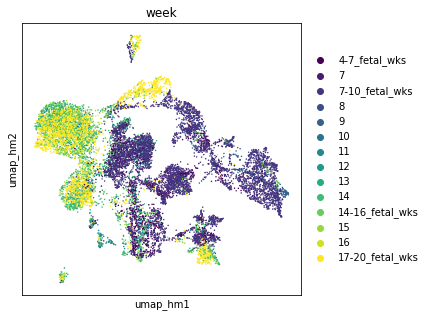

In [182]:
ss.lib.set_figsize((5,5))
ss.lib.plot_scatter(nr_pooled, basis='umap_hm', color=['week'], ncols=6, wspace=0.5, palette='viridis')

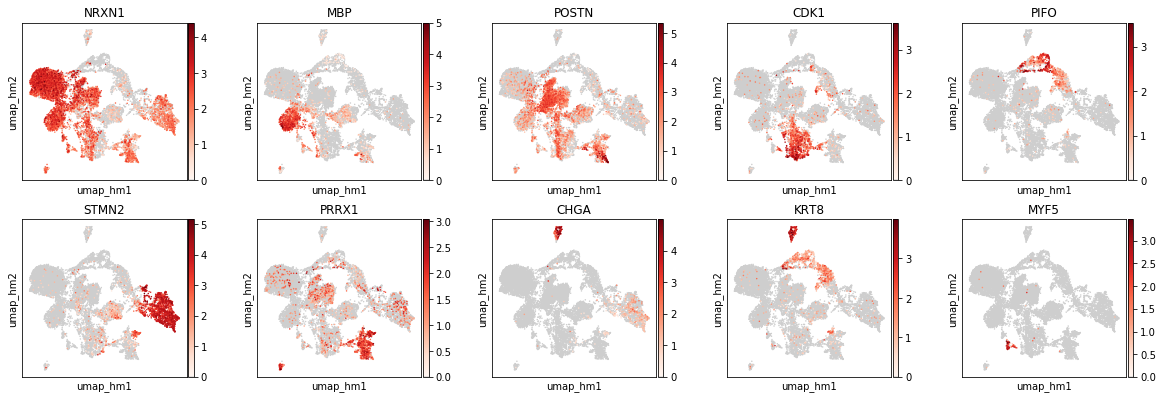

In [180]:
ss.lib.set_figsize((3,3))
ss.lib.plot_scatter(nr_pooled, basis='umap_hm', color=['NRXN1', 'MBP', 'POSTN', 'CDK1', 'PIFO', 'STMN2', 'PRRX1', 'CHGA', 'KRT8', 'MYF5'], ncols=5, wspace=0.3, color_map=expr_cmap)

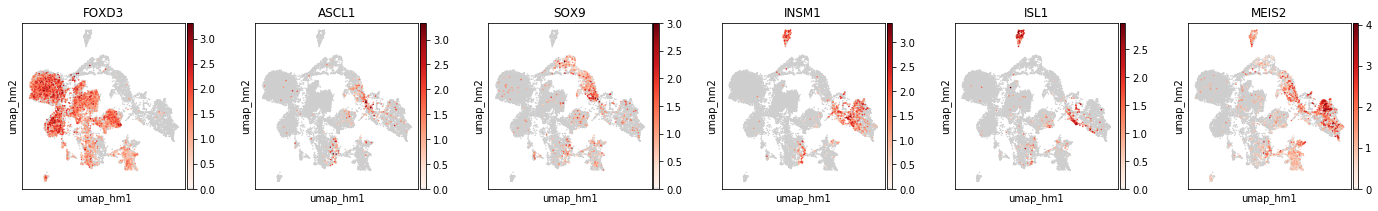

In [184]:
ss.lib.set_figsize((3,3))
ss.lib.plot_scatter(
    nr_pooled, basis='umap_hm', ncols=6, wspace=0.3, color_map=expr_cmap,
    color=['FOXD3', 'ASCL1', 'SOX9', 'INSM1', 'ISL1', 'MEIS2'])

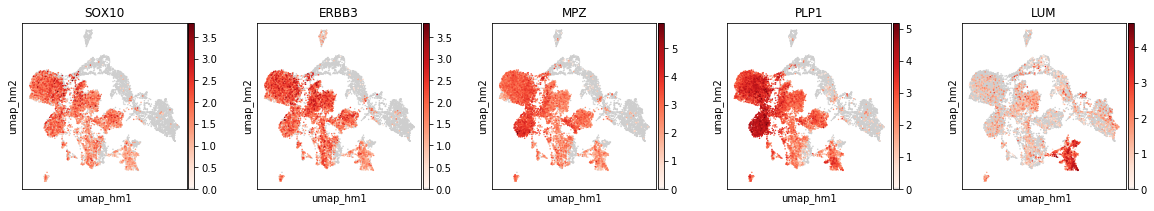

In [190]:
ss.lib.set_figsize((3,3))
ss.lib.plot_scatter(
    nr_pooled, basis='umap_hm', ncols=6, wspace=0.3, color_map=expr_cmap,
    color=['SOX10', 'ERBB3', 'MPZ', 'PLP1', 'LUM'])

In [ ]:
ss.lib.set_figsize((4,4))
ss.lib.plot_scatter(nr_pooled, basis='umap_hm', color=['dataset', 'batch'], ncols=6, wspace=0.5, palette='tab20')

In [ ]:
ss.lib.set_figsize((4,4))
ss.lib.plot_scatter(nr_pooled, basis='umap_hm', color=['leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7'], ncols=6, wspace=0.3)

In [119]:
nr_deg = ss.lib.diffexp(nr_pooled, groupby='leiden_hm_r0_1', filter_params='sc_default')

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [131]:
ss.lib.extract_de_table(nr_pooled.uns['rank_genes_groups']).groupby('cluster').head(4)

,cluster,ref,rank,genes,scores,logfoldchanges,pvals,pvals_adj
0,0,rest,0,S100A10,64.679207,2.706211,0.000000e+00,0.000000e+00
1,0,rest,1,S100A4,64.652817,3.752243,0.000000e+00,0.000000e+00
2,0,rest,2,S100A6,59.995148,2.772817,0.000000e+00,0.000000e+00
3,0,rest,3,NRXN1,54.102886,2.584646,0.000000e+00,0.000000e+00
18812,1,rest,0,POSTN,37.648357,2.957242,3.147506e-264,5.921087e-260
18813,1,rest,1,BCHE,36.811153,2.207459,6.074680e-258,5.713844e-254
18814,1,rest,2,CDH6,36.456551,2.617402,2.660345e-249,1.668214e-245
18815,1,rest,3,PLS3,33.933086,2.191653,1.824546e-222,8.580841e-219
37624,2,rest,0,CLU,39.514156,4.202529,1.713174e-261,2.929839e-258
37625,2,rest,1,MSX1,32.690170,5.206134,9.400142e-188,4.912096e-185


In [123]:
nr_deg.groupby('cluster').head(4)

,cluster,ref,rank,genes,scores,logfoldchanges,pvals,pvals_adj
37625,2,rest,1,MSX1,32.690170,5.206134,9.400142e-188,4.912096e-185
37626,2,rest,2,SPARCL1,31.325298,4.746702,7.883896e-177,3.617362e-174
37627,2,rest,3,PIFO,30.762283,6.172720,6.156738e-169,2.316411e-166
37628,2,rest,4,KRT18,28.965515,4.330950,1.251995e-157,3.991954e-155
56441,3,rest,5,MAD2L1,50.786125,4.730845,0.000000e+00,0.000000e+00
56444,3,rest,8,TOP2A,47.296158,5.692601,3.755575e-309,7.064987e-306
56445,3,rest,9,CENPF,46.479389,5.158944,1.586005e-307,2.712357e-304
56447,3,rest,11,UBE2C,45.247597,5.607773,9.682585e-291,1.517907e-287
75248,4,rest,0,STMN2,117.706276,7.507607,0.000000e+00,0.000000e+00
75258,4,rest,10,DCX,59.350899,5.884221,0.000000e+00,0.000000e+00


In [174]:
ss.lib.clear_colors(nr_pooled)

In [175]:
nr_pooled.write('pooled_neuronal.processed.h5ad', compression='lzf')

... storing 'gene_symbols-0-organoid' as categorical
... storing 'gene_symbols-1-organoid' as categorical
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/anndata/readwrite/write.py:308: UserWarning: Could not save field with key = 'uns/rank_genes_groups_filtered/names' to hdf5 file: invalid literal for int() with base 10: ''
  .format(key, e)
